In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
from scipy import sparse
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV, ShuffleSplit
from imblearn.over_sampling import RandomOverSampler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score 
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics import confusion_matrix, log_loss
from sklearn.calibration import CalibratedClassifierCV
import xgboost as xgb
import time

In [2]:
# Importing the dataset
traindata = pd.read_csv("data/train.csv")
testdata = pd.read_csv('data/test.csv')

In [3]:
traindata = traindata.dropna()
print(traindata.shape)

(404287, 6)


In [4]:
np.isnan(traindata.any())

id              False
qid1            False
qid2            False
question1       False
question2       False
is_duplicate    False
dtype: bool

In [5]:
traindata.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [6]:
labels = np.array(traindata["is_duplicate"])

In [7]:
features = pd.read_csv("data/train_set2_features.csv")

In [8]:
features.head()

,q1_char_num,q2_char_num,q1_word_num,q2_word_num,total_word_num,differ_word_num,same_first_word,same_last_word,total_unique_word_num,total_unique_word_withoutstopword_num,...,common_word_withoutstopword_ratio_max,fuzz_ratio,fuzz_QRatio,fuzz_WRatio,fuzz_partial_ratio,fuzz_token_set_ratio,fuzz_token_sort_ratio,fuzz_partial_token_set_ratio,fuzz_partial_token_sort_ratio,longest_substr_ratio
0,65,56,14,12,26,2,1,0,12,6,...,0.833333,93,93,95,100,100,93,100,89,0.982456
1,48,85,10,15,25,5,1,0,17,11,...,0.400000,63,63,86,73,86,62,100,73,0.571429
2,70,54,14,10,24,4,1,0,19,8,...,0.500000,52,52,69,56,73,65,100,69,0.181818
3,48,58,11,13,24,2,0,0,20,9,...,0.000000,36,36,36,40,37,36,37,38,0.040816
4,73,38,13,7,20,6,1,0,16,13,...,0.200000,45,45,86,55,67,47,100,63,0.153846


In [9]:
features.shape

(404287, 28)

In [10]:
np.isnan(features.all())

q1_char_num                              False
q2_char_num                              False
q1_word_num                              False
q2_word_num                              False
total_word_num                           False
differ_word_num                          False
same_first_word                          False
same_last_word                           False
total_unique_word_num                    False
total_unique_word_withoutstopword_num    False
total_unique_word_num_ratio              False
common_word_num                          False
common_word_ratio                        False
common_word_ratio_min                    False
common_word_ratio_max                    False
common_word_withoutstopword_num          False
common_word_withoutstopword_ratio        False
common_word_withoutstopword_ratio_min    False
common_word_withoutstopword_ratio_max    False
fuzz_ratio                               False
fuzz_QRatio                              False
fuzz_WRatio  

In [11]:
np.isfinite(features.all())

q1_char_num                              True
q2_char_num                              True
q1_word_num                              True
q2_word_num                              True
total_word_num                           True
differ_word_num                          True
same_first_word                          True
same_last_word                           True
total_unique_word_num                    True
total_unique_word_withoutstopword_num    True
total_unique_word_num_ratio              True
common_word_num                          True
common_word_ratio                        True
common_word_ratio_min                    True
common_word_ratio_max                    True
common_word_withoutstopword_num          True
common_word_withoutstopword_ratio        True
common_word_withoutstopword_ratio_min    True
common_word_withoutstopword_ratio_max    True
fuzz_ratio                               True
fuzz_QRatio                              True
fuzz_WRatio                       

In [12]:
features.replace((np.inf, -np.inf), np.nan, inplace=True)

In [13]:
features.fillna(method='bfill', inplace=True)

In [14]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404287 entries, 0 to 404286
Data columns (total 28 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   q1_char_num                            404287 non-null  int64  
 1   q2_char_num                            404287 non-null  int64  
 2   q1_word_num                            404287 non-null  int64  
 3   q2_word_num                            404287 non-null  int64  
 4   total_word_num                         404287 non-null  int64  
 5   differ_word_num                        404287 non-null  int64  
 6   same_first_word                        404287 non-null  int64  
 7   same_last_word                         404287 non-null  int64  
 8   total_unique_word_num                  404287 non-null  int64  
 9   total_unique_word_withoutstopword_num  404287 non-null  int64  
 10  total_unique_word_num_ratio            404287 non-null  

In [15]:
features = features.to_numpy()

In [16]:
scaler = MinMaxScaler()

In [17]:
features = scaler.fit_transform(features)

In [18]:
features

array([[0.11111111, 0.05049594, 0.109375  , ..., 1.        , 0.89      ,
        0.98734398],
       [0.08205128, 0.07664563, 0.078125  , ..., 1.        , 0.73      ,
        0.5742715 ],
       [0.11965812, 0.04869252, 0.109375  , ..., 1.        , 0.69      ,
        0.18272275],
       ...,
       [0.02735043, 0.01532913, 0.03125   , ..., 1.        , 0.75      ,
        0.47292947],
       [0.14871795, 0.10820559, 0.1328125 , ..., 1.        , 0.45      ,
        0.05710086],
       [0.06153846, 0.03967538, 0.0625    , ..., 1.        , 0.92      ,
        0.62471427]])

Since the dataset is imbalanced, we did oversample by sampling from the minority class.

In [19]:
oversample = RandomOverSampler(sampling_strategy='minority')
X_data, y_data = oversample.fit_resample(features, labels)

In [20]:
print(np.count_nonzero(y_data == 0))
print(np.count_nonzero(y_data == 1))

255024
255024


Now we have 510048 data points. 255024 from each class.

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

# Models Training

## Support Vector Classifier (SVM Classifier)

In [22]:
splits = ShuffleSplit(n_splits=1, test_size=0.3, random_state=42)

In [23]:
svc_param_grid = {'C':[1e-2, 1e-1, 1e0, 1e1, 1e2]}

In [24]:
svc_clf = LinearSVC(penalty='l2', loss='squared_hinge', dual=False, max_iter=3000)

In [25]:
svc_clf_search = HalvingGridSearchCV(svc_clf, svc_param_grid, cv=splits, factor=2, scoring='accuracy', verbose=3)

In [26]:
svc_clf_search.fit(X_train, y_train)

n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 102009
max_resources_: 408038
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 5
n_resources: 102009
Fitting 1 folds for each of 5 candidates, totalling 5 fits
[CV 1/1] END .........................................C=0.01; total time=   0.6s
[CV 1/1] END ..........................................C=0.1; total time=   0.9s
[CV 1/1] END ..........................................C=1.0; total time=   1.6s
[CV 1/1] END .........................................C=10.0; total time=   2.5s
[CV 1/1] END ........................................C=100.0; total time=   3.6s
----------
iter: 1
n_candidates: 3
n_resources: 204018
Fitting 1 folds for each of 3 candidates, totalling 3 fits
[CV 1/1] END .........................................C=10.0; total time=   5.2s
[CV 1/1] END ..........................................C=1.0; total time=   3.9s
[CV 1/1] END ........................................

HalvingGridSearchCV(cv=ShuffleSplit(n_splits=1, random_state=42, test_size=0.3, train_size=None),
                    estimator=LinearSVC(dual=False, max_iter=3000), factor=2,
                    param_grid={'C': [0.01, 0.1, 1.0, 10.0, 100.0]},
                    refit=<function _refit_callable at 0x000001C38C64D040>,
                    scoring='accuracy', verbose=3)

In [27]:
svc_clf_search.best_params_

{'C': 100.0}

In [28]:
svc_clf_search.best_score_

0.7101485977567376

In [29]:
svc_clf_model = svc_clf_search.best_estimator_

In [30]:
svc_clf_model

LinearSVC(C=100.0, dual=False, max_iter=3000)

In [31]:
svc_calibrated = CalibratedClassifierCV(base_estimator=svc_clf_model, method="sigmoid", cv=splits)

In [32]:
svc_calibrated.fit(X_train, y_train)

CalibratedClassifierCV(base_estimator=LinearSVC(C=100.0, dual=False,
                                                max_iter=3000),
                       cv=ShuffleSplit(n_splits=1, random_state=42, test_size=0.3, train_size=None))

### Evaluation

Accuracy:  0.70905793549652
Precision:  0.6861929057760286
Recall:  0.7716982610057966
F1:  0.7264381377257099
ROC AUC:  0.7089853924272889
              precision    recall  f1-score   support

           0       0.74      0.65      0.69     50946
           1       0.69      0.77      0.73     51064

    accuracy                           0.71    102010
   macro avg       0.71      0.71      0.71    102010
weighted avg       0.71      0.71      0.71    102010



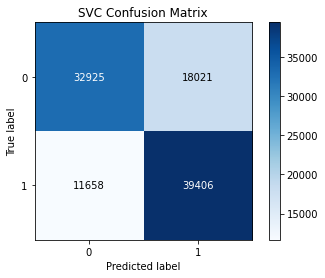

In [33]:
y_pred = svc_calibrated.predict(X_test)

print("Accuracy: ", accuracy_score(y_test, y_pred))
print("Precision: ", precision_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred))
print("F1: ", f1_score(y_test, y_pred))
print("ROC AUC: ", roc_auc_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

import scikitplot as skplt
skplt.metrics.plot_confusion_matrix(y_test, y_pred)
plt.title('SVC Confusion Matrix')
plt.savefig('graphs/svc_fs2/svc_confusion_matrix.png')

## Logistic Regression

In [34]:
lr_param_grid = {'C':[1e-2, 1e-1, 1e0, 1e1, 1e2]}

In [35]:
lr_clf = LogisticRegression(penalty='l2', class_weight='balanced', dual=False, max_iter=3000)

In [36]:
lr_clf_search = HalvingGridSearchCV(lr_clf, lr_param_grid, cv=splits, factor=2, scoring='accuracy', verbose=3)

In [37]:
lr_clf_search.fit(X_train, y_train)

n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 102009
max_resources_: 408038
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 5
n_resources: 102009
Fitting 1 folds for each of 5 candidates, totalling 5 fits
[CV 1/1] END .........................................C=0.01; total time=   0.2s
[CV 1/1] END ..........................................C=0.1; total time=   0.8s
[CV 1/1] END ..........................................C=1.0; total time=   1.5s
[CV 1/1] END .........................................C=10.0; total time=   4.2s
[CV 1/1] END ........................................C=100.0; total time=   7.8s
----------
iter: 1
n_candidates: 3
n_resources: 204018
Fitting 1 folds for each of 3 candidates, totalling 3 fits
[CV 1/1] END .........................................C=10.0; total time=  12.5s
[CV 1/1] END ........................................C=100.0; total time=  10.6s
[CV 1/1] END ........................................

HalvingGridSearchCV(cv=ShuffleSplit(n_splits=1, random_state=42, test_size=0.3, train_size=None),
                    estimator=LogisticRegression(class_weight='balanced',
                                                 max_iter=3000),
                    factor=2, param_grid={'C': [0.01, 0.1, 1.0, 10.0, 100.0]},
                    refit=<function _refit_callable at 0x000001C38C64D040>,
                    scoring='accuracy', verbose=3)

In [38]:
lr_clf_search.best_params_

{'C': 100.0}

In [39]:
lr_clf_search.best_score_

0.7088415256798817

In [40]:
lr_clf_model = lr_clf_search.best_estimator_

In [41]:
lr_clf_model

LogisticRegression(C=100.0, class_weight='balanced', max_iter=3000)

### Evaluation

Accuracy:  0.7099303989804921
Precision:  0.6842060115289597
Recall:  0.7810003133322889
F1:  0.7294059550808399
ROC AUC:  0.709848093697511
              precision    recall  f1-score   support

           0       0.74      0.64      0.69     50946
           1       0.68      0.78      0.73     51064

    accuracy                           0.71    102010
   macro avg       0.71      0.71      0.71    102010
weighted avg       0.71      0.71      0.71    102010



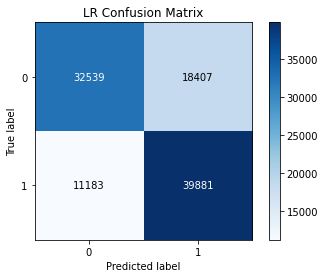

In [42]:
y_pred = lr_clf_model.predict(X_test)

print("Accuracy: ", accuracy_score(y_test, y_pred))
print("Precision: ", precision_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred))
print("F1: ", f1_score(y_test, y_pred))
print("ROC AUC: ", roc_auc_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

import scikitplot as skplt
skplt.metrics.plot_confusion_matrix(y_test, y_pred)
plt.title('LR Confusion Matrix')
plt.savefig('graphs/lr_fs2/lr_confusion_matrix.png')

## Random Forest Classifier

In [43]:
rf_param_grid = {
                    'n_estimators':[200, 500, 800], 
                    'min_samples_split':[5, 15],
                    'max_depth': [70, 150, None]
                }

In [44]:
rf_clf = RandomForestClassifier()

In [45]:
rf_clf_search = HalvingGridSearchCV(rf_clf, rf_param_grid, cv=splits, factor=2, scoring='accuracy', verbose=3)

In [46]:
rf_clf_search.fit(X_train, y_train)

n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 25502
max_resources_: 408038
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 18
n_resources: 25502
Fitting 1 folds for each of 18 candidates, totalling 18 fits
[CV 1/1] END max_depth=70, min_samples_split=5, n_estimators=200; total time=   7.2s
[CV 1/1] END max_depth=70, min_samples_split=5, n_estimators=500; total time=  17.7s
[CV 1/1] END max_depth=70, min_samples_split=5, n_estimators=800; total time=  29.5s
[CV 1/1] END max_depth=70, min_samples_split=15, n_estimators=200; total time=   6.4s
[CV 1/1] END max_depth=70, min_samples_split=15, n_estimators=500; total time=  16.4s
[CV 1/1] END max_depth=70, min_samples_split=15, n_estimators=800; total time=  26.3s
[CV 1/1] END max_depth=150, min_samples_split=5, n_estimators=200; total time=   7.0s
[CV 1/1] END max_depth=150, min_samples_split=5, n_estimators=500; total time=  17.7s
[CV 1/1] END max_depth=150, min_samples_split=5,

HalvingGridSearchCV(cv=ShuffleSplit(n_splits=1, random_state=42, test_size=0.3, train_size=None),
                    estimator=RandomForestClassifier(), factor=2,
                    param_grid={'max_depth': [70, 150, None],
                                'min_samples_split': [5, 15],
                                'n_estimators': [200, 500, 800]},
                    refit=<function _refit_callable at 0x000001C38C64D040>,
                    scoring='accuracy', verbose=3)

In [47]:
rf_clf_search.best_params_

{'max_depth': None, 'min_samples_split': 5, 'n_estimators': 500}

In [48]:
rf_clf_search.best_score_

0.8149660975410505

In [49]:
rf_clf_model = rf_clf_search.best_estimator_

In [50]:
rf_clf_model

RandomForestClassifier(min_samples_split=5, n_estimators=500)

### Evaluation

Accuracy:  0.8324772081168513
Precision:  0.788799918396491
Recall:  0.9086244712517625
F1:  0.844482868453383
ROC AUC:  0.8323890228123139
              precision    recall  f1-score   support

           0       0.89      0.76      0.82     50946
           1       0.79      0.91      0.84     51064

    accuracy                           0.83    102010
   macro avg       0.84      0.83      0.83    102010
weighted avg       0.84      0.83      0.83    102010



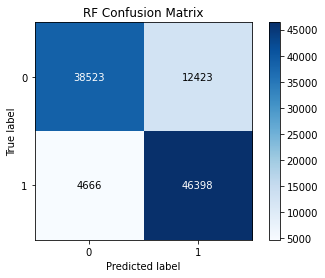

In [51]:
y_pred = rf_clf_model.predict(X_test)

print("Accuracy: ", accuracy_score(y_test, y_pred))
print("Precision: ", precision_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred))
print("F1: ", f1_score(y_test, y_pred))
print("ROC AUC: ", roc_auc_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

import scikitplot as skplt
skplt.metrics.plot_confusion_matrix(y_test, y_pred)
plt.title('RF Confusion Matrix')
plt.savefig('graphs/rf_fs2/rf_confusion_matrix.png')

## XGBoost

In [52]:
import hyperopt
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import warnings

In [53]:
def objective(space):
    warnings.filterwarnings(action='ignore', category=UserWarning)
    classifier = xgb.XGBClassifier(
                    objective = "binary:logistic",
                    eval_metric = "logloss",
                    booster = "gbtree",
                    tree_method = "hist",
                    grow_policy = "lossguide",
                    n_estimators = 300, 
                    max_depth = space['max_depth'],
                    learning_rate = space['learning_rate'],
                )
    
    classifier.fit(X_train, y_train)
    
    predicted_probs = classifier.predict_proba(X_test)

    logloss = log_loss(y_test, predicted_probs)

    print("Log loss = " + str(logloss))

    return{'loss':logloss, 'status': STATUS_OK }

In [54]:
space = {
    'max_depth' : hp.choice('max_depth', range(4, 10, 1)),
    "learning_rate": hp.quniform("learning_rate", 0.01, 0.5, 0.01)
}

In [55]:
trials = Trials()
best_param = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=5,
            trials=trials)

Log loss = 0.4465008484748546                                                                                          
Log loss = 0.4617677679800752                                                                                          
Log loss = 0.4359004888421046                                                                                          
Log loss = 0.41206901949599295                                                                                         
Log loss = 0.4459102753193511                                                                                          
100%|█████████████████████████████████████████████████| 5/5 [01:00<00:00, 12.10s/trial, best loss: 0.41206901949599295]


In [56]:
print("Best Param : ", best_param)

Best Param :  {'learning_rate': 0.37, 'max_depth': 5}


#### Training the model with the tuned parameters.

In [61]:
params = dict(
            objective = "binary:logistic",
            eval_metric = "logloss",
            booster = "gbtree",
            tree_method = "hist",
            grow_policy = "lossguide",
            max_depth = 5,
            eta = 0.37
        )

In [58]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_test, label=y_test)

In [59]:
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

In [62]:
xgb_model = xgb.train(params, dtrain, 1000, watchlist, early_stopping_rounds=20, verbose_eval=10)

[0]	train-logloss:0.60348	valid-logloss:0.60407
[10]	train-logloss:0.49270	valid-logloss:0.49517
[20]	train-logloss:0.48072	valid-logloss:0.48384
[30]	train-logloss:0.47480	valid-logloss:0.47872
[40]	train-logloss:0.47009	valid-logloss:0.47518
[50]	train-logloss:0.46715	valid-logloss:0.47311
[60]	train-logloss:0.46460	valid-logloss:0.47155
[70]	train-logloss:0.46201	valid-logloss:0.47023
[80]	train-logloss:0.45942	valid-logloss:0.46874
[90]	train-logloss:0.45744	valid-logloss:0.46760
[100]	train-logloss:0.45550	valid-logloss:0.46670
[110]	train-logloss:0.45329	valid-logloss:0.46559
[120]	train-logloss:0.45109	valid-logloss:0.46440
[130]	train-logloss:0.44953	valid-logloss:0.46369
[140]	train-logloss:0.44761	valid-logloss:0.46266
[150]	train-logloss:0.44623	valid-logloss:0.46213
[160]	train-logloss:0.44447	valid-logloss:0.46130
[170]	train-logloss:0.44293	valid-logloss:0.46052
[180]	train-logloss:0.44176	valid-logloss:0.45985
[190]	train-logloss:0.44030	valid-logloss:0.45919
[200]	train

In [63]:
xgb_clf = xgb.XGBClassifier(
                    objective = "binary:logistic",
                    eval_metric = "logloss",
                    booster = "gbtree",
                    tree_method = "hist",
                    grow_policy = "lossguide",
                    n_estimators = 300, 
                    max_depth = '5',
                    learning_rate = '0.37',
                )
    
xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=0, gpu_id=-1, grow_policy='lossguide',
              importance_type='gain', interaction_constraints='',
              learning_rate='0.37', max_delta_step=0, max_depth='5',
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=300, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='hist', validate_parameters=1, verbosity=None)

### Evaluation

Log Loss:  0.45322054312013726
Accuracy:  0.772090971473385
Precision:  0.7323609509966084
Recall:  0.8584129719567601
F1:  0.7903928162499888
ROC AUC:  0.7719910029178846
              precision    recall  f1-score   support

           0       0.83      0.69      0.75     50946
           1       0.73      0.86      0.79     51064

    accuracy                           0.77    102010
   macro avg       0.78      0.77      0.77    102010
weighted avg       0.78      0.77      0.77    102010



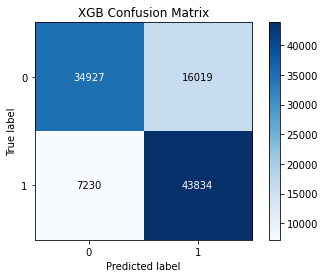

In [64]:
y_predicted_probs = xgb_clf.predict_proba(X_test)

y_pred = xgb_clf.predict(X_test)

print("Log Loss: ", log_loss(y_test, y_predicted_probs))
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("Precision: ", precision_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred))
print("F1: ", f1_score(y_test, y_pred))
print("ROC AUC: ", roc_auc_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

import scikitplot as skplt
skplt.metrics.plot_confusion_matrix(y_test, y_pred)
plt.title('XGB Confusion Matrix')
plt.savefig('graphs/xgb_fs2/xgb_confusion_matrix.png')